# Proyecto Enseña Chile – Análisis de Reclutamiento

Este notebook tiene como objetivo analizar datos históricos de postulantes a Enseña Chile y cruzarlos con información externa del MINEDUC para identificar universidades y carreras con mayor concentración de candidatos idóneos, ayudando así a mejorar el proceso de reclutamiento.

## Objetivos específicos:
1. Caracterizar históricamente a postulantes y seleccionados.
2. Analizar la relación universidad-carrera-selección.
3. Identificar universidades y carreras prioritarias.
4. Proponer una categorización en niveles de prioridad.

# Entrega Inicial del Repositorio

## Contexto y motivación

Enseña Chile es una fundación que busca atraer profesionales talentosos al mundo educativo para
generar un impacto real en las comunidades escolares más vulnerables del país.

No obstante, sus procesos de postulación enfrentan desafíos importantes: la tasa de aceptación suele
ser baja y los perfiles de quienes postulan parecen ser bastante heterogéneos.

Este proyecto apunta a utilizar los datos históricos de postulaciones de Enseña Chile, junto con
información universitaria disponible en fuentes públicas como el MINEDUC, para detectar patrones,
brechas y oportunidades de mejora en el reclutamiento y selección del programa. La idea es elaborar
recomendaciones estratégicas que ayuden a la Fundación a focalizar mejor sus esfuerzos, diversificar
el perfil de candidatos y aumentar la probabilidad de éxito en las postulaciones.

La audiencia principal de este trabajo está compuesta por el equipo de gestión de Enseña Chile, aunque
también busca ser un aporte para investigadores y responsables de políticas educativas interesados en
comprender con mayor claridad cómo se distribuye el talento docente potencial en el país.

## Preguntas objetivo

¿Qué características académicas y sociodemográficas se correlacionan con un mayor éxito en el proceso de selección de Enseña Chile?

¿Existen universidades o carreras que presenten consistentemente una mayor proporción de postulantes aceptados?

¿Qué regiones del país presentan menor participación o tasa de éxito en postulaciones?

¿Es posible construir un modelo predictivo que estime la probabilidad de éxito de un postulante en función de sus características iniciales?

¿Cómo se pueden utilizar estos hallazgos para focalizar los esfuerzos de reclutamiento y reducir posibles sesgos hacia ciertas instituciones de elite?

## Datos

Datos internos de Enseña Chile:
- Registros históricos de postulaciones:
  
    - Columnas `Generación`/`Año pech`: Año de la generación donde seleccionado iniciaría su primer año de colegio
    - Columnas `# Proceso`/`Proceso`: Procesos de postulación según fechas que se deciden cada año. De 1 a 3 anuales
     - Columna `Edad`: Edad del postulante
     - Columna `Resumen Estado Postulación`: Si está en proceso, fuera del proceso o seleccionado.
    - Columna `Estado de la Postulación`: Depende de la etapa en que se encuentra
    - Siglas usadas en celdas:
        - DE: Día de Entrevista (Etapa de selección antigua)
        - PR: Primera Revisión (Formulario: filtro 1)
        - ET: Entrevista Telefónica (filtro 1.1)
        - EG: Entrevista Grupal (filtro 2)
        - EP: Entrevista Personal (filtro 3)








Datos externos (fuentes públicas):
- Distribución de estudiantes universitarios por institución, región y carrera.
- Información de equidad y brechas (ej. género, tipo de institución).

Datos DEMRE:
- Puntajes PAES de matrícula, por año, provistos por datos abiertos del Departamento de
Medición, Evaluación y Registro Educacional de la Universidad de Chile.



## Análisis exploratorio de los datos

# 1 Configuracion inicial

## 1.1 Bibliotecas

In [1]:
!pip install lxml

In [2]:
!pip install python-magic

In [3]:
!pip install python-magic-bin

Este notebook se desarrolló en Google Colab, donde el almacenamiento de archivos es solo temporal, por tanto, para que no tuvieramos que subir los archivos necesarios cada vez que quisieramos correr el notebook, usamos la libreria `gdown` para automatizar la descarga de archivos desde nuestra carpeta del proyecto en Google Drive.

In [4]:
!pip install gdown
import gdown

In [5]:
import magic
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import json

In [6]:
# Configuraciones de visualizacion
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

## 1.2 Descarga de archivos

In [7]:
url_drive = "https://drive.google.com/uc?id="

In [8]:
por_descargar = {'1hrwPpacqX8hg41KQG_7Yr-jhVPmYCSLr': Path("datasets/Postulaciones historicas ECh ORIGINAL.xls"),
                 '1apwRW4Evdr1vuPeOawA_oIef1_ay_Hco': Path("datasets/Postulaciones historicas ECh.csv"),
                 '1hePtnwicwz_fv-hwF7S_3bRIwvb7gfC3': Path("imagenes/ultimas filas.png"),
                 '12SGs7YOE4uzXqX3MpwZDUpk_IviKAvkI': Path("mapeos/carreras.json")}
                #'1NV_TQSis9q7Btoaa7Wmvgc9XCWQ4Xtaz': Path("datasets/titulados.csv")

In [9]:
for id_archivo, ruta_archivo in por_descargar.items():
    # Obtenemos el directorio padre
    directorio_padre = ruta_archivo.parent 
    
    # Creamos el directorio
    directorio_padre.mkdir(parents=True, exist_ok=True)
    
    # Abrir en modo binario
    with ruta_archivo.open("wb") as archivo:
        print(f'Descargando "{ruta_archivo.name}"...')
        gdown.download(url_drive + id_archivo, archivo, quiet=True)
        print('Descarga completa\n')

Descargando "Postulaciones historicas ECh ORIGINAL.xls"...
Descarga completa

Descargando "Postulaciones historicas ECh.csv"...
Descarga completa

Descargando "ultimas filas.png"...
Descarga completa

Descargando "carreras.json"...
Descarga completa



# 2 Carga y Exploración Inicial de los Datos

## 2.1 Postulantes

### 2.1.1 Crear DataFrame

El archivo que nos entregaron tiene extensión `.xls`, formato usado desde Excel 97 a Excel 2003, predecesor del actual `.xlsx` introducido en Excel 2007. <br>
Intentamos cargarlo con `read_excel()`

In [21]:
ruta_xls = Path("datasets/Postulaciones historicas ECh ORIGINAL.xls")
try:
    with open(ruta_xls) as archivo:
        df_postulantes = pd.read_excel(archivo)
except Exception as e:
    print(f"{type(e).__name__}: {e}")

ValueError: Excel file format cannot be determined, you must specify an engine manually.


inspeccionamos el tipo de archivo

In [22]:
tipo_archivo = magic.from_file(str(ruta_xls))
print(tipo_archivo)

HTML document, ISO-8859 text, with very long lines, with CRLF, LF line terminators


intentamos cargar como html

In [23]:
df_postulantes = pd.read_html(ruta_xls)

intentamos mostrar las primeras filas

In [24]:
try:
    df_postulantes.head()
except Exception as e:
    print(f"{type(e).__name__}: {e}")

AttributeError: 'list' object has no attribute 'head'


investigando nos damos cuenta de que `read_html()` retorna una lista de dataframes. <br>
imprimimos cuantos hay

In [25]:
lista_html = df_postulantes
len(lista_html)

1

mostramos el que contiene

In [26]:
df_postulantes = lista_html[0]
display(df_postulantes.head())
display(df_postulantes.tail())

,Año Pech,Generación,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
0,2021.0,NaN,NaN,3.0,37.0,Seleccionado,Acepta compromiso peCh,Astrid,Vega Escobedo,U. Santo Tomás (Santiago),NaN,Fonoaudiología,NaN,NaN,NaN
1,2021.0,NaN,NaN,1.0,29.0,Seleccionado,Acepta compromiso peCh,Macarena Alejandra,Buschmann Cambiaso,Pontificia U. Católica de Chile,NaN,Ingeniería Comercial,NaN,NaN,NaN
2,2020.0,NaN,NaN,1.0,31.0,Seleccionado,Acepta compromiso peCh,Martín,Jaeger,U. de Chile,NaN,Economía,NaN,NaN,NaN
3,2021.0,NaN,NaN,1.0,30.0,Seleccionado,Acepta compromiso peCh,María Ignacia,Gibson,U. de Chile,NaN,Ingeniería Comercial,NaN,NaN,NaN
4,2021.0,NaN,NaN,1.0,35.0,Seleccionado,Acepta compromiso peCh,Evelyn,Espinosa,U. Andrés Bello (Santiago),NaN,Bioquímica,NaN,NaN,NaN


,Año Pech,Generación,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
71623,2025.0,2025.0,NaN,10.0,35.0,Seleccionado,Acepta compromiso peCh,Moisés Ignacio,Álvarez Riquelme,U. de Santiago de Chile,NaN,Ingeniería de Ejecución (todas las especialida...,Ingeniería Civil otra mención,NaN,NaN
71624,2030.0,2030.0,NaN,1.0,28.0,Seleccionado,Aceptado a EG,Valentina,Test,U. de Santiago de Chile,NaN,Ingeniería de Ejecución (todas las especialida...,NaN,NaN,NaN
71625,2030.0,2030.0,NaN,1.0,NaN,Seleccionado,Aceptado en DE,Jennifer,Test,NaN,NaN,NaN,NaN,NaN,NaN
71626,2030.0,2030.0,NaN,1.0,28.0,Fuera del proceso,Rechazado en DE,Tamara,Test,U. Alberto Hurtado,NaN,Ciencia Política / Licenciatura en Ciencia Pol...,NaN,NaN,NaN
71627,2030.0,2030.0,NaN,3.0,39.0,Seleccionado,Acepta compromiso peCh,Tester,Area TI,U. Técnica Federico Santa María (Santiago),U. Andrés Bello (Santiago),Ingeniería Civil Electrónica,NaN,asas,NaN


Captura de pantalla de las ultimas filas del dataset en Excel:

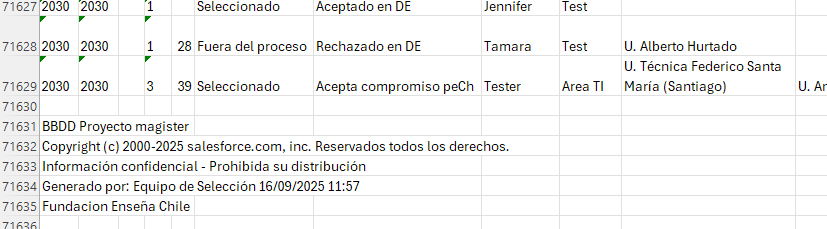

In [27]:
Image(Path("imagenes/ultimas filas.png"))

 Comparando la cola con lo que muestra Excel, a nuestro dataframe le faltan las ultimas 6 filas. <br>
 A pesar de que las filas extraviadas no son relevantes para nuestro analisis, el formato del archivo no nos da confianza. Puede que hayan mas celdas que se perdieron durante la carga. Para maximizar la compatibilidad optamos por exportar el archivo a un `.csv` con Excel y lo cargamos con `read_csv()`

In [28]:
ruta_csv = Path("datasets/Postulaciones historicas ECh.csv")
df_postulantes = pd.read_csv(ruta_csv, low_memory=False)
# low_memory=False para que pandas infiera los tipos de datos despues de leer todo el archivo
# y asi no terminar con columnas con multiples tipos de datos

el `DtypeWarning` nos avisa que en la columna 0 hay varios tipos de datos, por tanto `pandas` dejó todas esas entradas como tipo `object`

In [29]:
with pd.option_context('display.max_colwidth', None):
    display(df_postulantes.tail(8))

,Año Pech,Generación,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
71626,2030,2030.0,NaN,1.0,28.0,Fuera del proceso,Rechazado en DE,Tamara,Test,U. Alberto Hurtado,NaN,Ciencia Política / Licenciatura en Ciencia Política,NaN,NaN,NaN
71627,2030,2030.0,NaN,3.0,39.0,Seleccionado,Acepta compromiso peCh,Tester,Area TI,U. Técnica Federico Santa María (Santiago),U. Andrés Bello (Santiago),Ingeniería Civil Electrónica,NaN,asas,NaN
71628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71629,BBDD Proyecto magister,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71630,"Copyright (c) 2000-2025 salesforce.com, inc. Reservados todos los derechos.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71631,Información confidencial - Prohibida su distribución,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71632,Generado por: Equipo de Selección 16/09/2025 11:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71633,Fundacion Enseña Chile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ahora sí se muestran las observaciones del final. Además, contando las filas desde 0 (en vez de 1) y no considerando el encabezado, las dimensiones del dataframe son iguales a las de la tabla mostrada en Excel.

### 2.1.2 Primer vistazo

Resumen de las columnas

In [30]:
df_postulantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71634 entries, 0 to 71633
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Año Pech                    67994 non-null  object 
 1   Generación                  67967 non-null  float64
 2   # Proceso                   824 non-null    float64
 3   Proceso                     67559 non-null  float64
 4   Edad                        71094 non-null  float64
 5   Resumen Estado Postulación  71627 non-null  object 
 6   Estado de la Postulación    71628 non-null  object 
 7   Nombre                      71624 non-null  object 
 8   Apellidos                   71628 non-null  object 
 9   Universidad                 40966 non-null  object 
 10  Universidad (old)           31093 non-null  object 
 11  Carrera                     67930 non-null  object 
 12  Carrera.1                   3735 non-null   object 
 13  Otra Carrera                912

Cantidad de datos nulos en el Dataframe por columna

In [31]:
df_postulantes.isnull().sum()

Año Pech                       3640
Generación                     3667
# Proceso                     70810
Proceso                        4075
Edad                            540
Resumen Estado Postulación        7
Estado de la Postulación          6
Nombre                           10
Apellidos                         6
Universidad                   30668
Universidad (old)             40541
Carrera                        3704
Carrera.1                     67899
Otra Carrera                  70722
Otra carrera, ¿Cuál?          70913
dtype: int64

mostrar estadisticas por columna

In [32]:
df_postulantes.describe(include='all')

,Año Pech,Generación,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
count,67994,67967.000000,824.000000,67559.000000,71094.000000,71627,71628,71624,71628,40966,31093,67930,3735,912,721
unique,23,NaN,NaN,NaN,NaN,4,32,28397,55064,94,77,245,131,726,656
top,2023,NaN,NaN,NaN,NaN,Incompleta,Postulación incompleta,Daniela,Muñoz,Otra,Otra,Otra,Otra,Ingeniero en prevención de riesgos,Derecho
freq,9909,NaN,NaN,NaN,NaN,42687,42688,522,64,4963,2911,4162,220,13,5
mean,NaN,2018.166581,1.188107,2.115913,38.225842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,3.374980,0.391035,1.129545,9.643208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2009.000000,1.000000,0.000000,-950.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2015.000000,1.000000,1.000000,33.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2018.000000,1.000000,2.000000,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2021.000000,1.000000,3.000000,41.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.2 Datos Titulados 2024 (Entrega 2)

In [33]:
#df_titulados = pd.read_csv("/content/titulados.csv", sep=';')

In [34]:
#df_titulados.head()

# 3 Limpieza de Datos
**Objetivo:** Eliminar duplicados, manejar valores nulos, convertir tipos de datos, y estandarizar categorías.

## 3.1 Eliminar filas con observaciones

In [35]:
filas_antes = df_postulantes.shape[0]
df_postulantes = df_postulantes.iloc[:-5]
filas_despues = df_postulantes.shape[0]
eliminadas = filas_antes - filas_despues
print(f"Se eliminaron las {eliminadas} ultimas filas.")

Se eliminaron las 5 ultimas filas.


## 3.2 Eliminar filas vacias

In [36]:
filas_antes = df_postulantes.shape[0]
filas_vacias = df_postulantes.isnull().all(axis=1)
df_postulantes = df_postulantes[~filas_vacias]
filas_despues = df_postulantes.shape[0]
eliminadas = filas_antes - filas_despues
print(f"Se eliminaron {eliminadas} filas vacias.")

Se eliminaron 1 filas vacias.


## 3.3 Eliminar duplicados

In [37]:
filas_antes = df_postulantes.shape[0]
df_postulantes.drop_duplicates(inplace=True)
filas_despues = df_postulantes.shape[0]
eliminadas = filas_antes - filas_despues
print(f"Se eliminaron {eliminadas} filas duplicadas.")

Se eliminaron 865 filas duplicadas.


## 3.4 Columnas `Año Pech` y `Generación`

### 3.4.1 Convertir a Int64

In [38]:
df_postulantes = df_postulantes.astype({'Año Pech': 'Int64', 'Generación': 'Int64'})

### 3.4.2 Datos conflictivos

In [39]:
con_annos_distintos = (df_postulantes['Año Pech'].notna()
                     & df_postulantes['Generación'].notna()
                     & (df_postulantes['Año Pech'] != df_postulantes['Generación']))

df_postulantes[con_annos_distintos]

,Año Pech,Generación,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"


seba: no hay conflictos entre annos

### 3.4.3 unir columnas

In [40]:
df_postulantes['Año Pech'] = df_postulantes['Año Pech'].combine_first(df_postulantes['Generación'])

df_postulantes = df_postulantes.rename(columns={'Año Pech': 'Año'})

df_postulantes = df_postulantes.drop(columns='Generación')

df_postulantes.head(1)

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
0,2021,NaN,3.0,37.0,Seleccionado,Acepta compromiso peCh,Astrid,Vega Escobedo,U. Santo Tomás (Santiago),NaN,Fonoaudiología,NaN,NaN,NaN


### 3.4.4 revisar datos extraños

In [41]:
print(np.sort(df_postulantes['Año'].unique().dropna()))

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023 2024 2025 2030]


#### revisar filas con anno 2030

In [42]:
con_anno_2030 = (df_postulantes['Año'] == 2030).fillna(False)
df_postulantes[con_anno_2030]

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
71624,2030,NaN,1.0,28.0,Seleccionado,Aceptado a EG,Valentina,Test,U. de Santiago de Chile,NaN,Ingeniería de Ejecución (todas las especialida...,NaN,NaN,NaN
71625,2030,NaN,1.0,NaN,Seleccionado,Aceptado en DE,Jennifer,Test,NaN,NaN,NaN,NaN,NaN,NaN
71626,2030,NaN,1.0,28.0,Fuera del proceso,Rechazado en DE,Tamara,Test,U. Alberto Hurtado,NaN,Ciencia Política / Licenciatura en Ciencia Pol...,NaN,NaN,NaN
71627,2030,NaN,3.0,39.0,Seleccionado,Acepta compromiso peCh,Tester,Area TI,U. Técnica Federico Santa María (Santiago),U. Andrés Bello (Santiago),Ingeniería Civil Electrónica,NaN,asas,NaN


por los nombres se infiere que fueron filas de testeo que a los encargados de la base de datos se les olvidó quitar <br>
por tanto las eliminamos

In [43]:
filas_antes = df_postulantes.shape[0]
df_postulantes = df_postulantes[~con_anno_2030]
filas_despues = df_postulantes.shape[0]
eliminadas = filas_antes - filas_despues
print(f"Se eliminaron {eliminadas} filas")

Se eliminaron 4 filas


## 3.5 Columnas `# Proceso` y `Proceso`

### 3.5.1 Convertir a `Int64`

In [44]:
df_postulantes = df_postulantes.astype({'# Proceso': 'Int64', 'Proceso': 'Int64'})

### 3.5.2 datos conflictivos

In [45]:
con_procesos_distintos = (df_postulantes['# Proceso'].notna()
                          & df_postulantes['Proceso'].notna()
                          & (df_postulantes['# Proceso'] != df_postulantes['Proceso']))

df_postulantes[con_procesos_distintos]

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
3148,<NA>,1,2,39.0,En proceso de selección,Aceptado a EG,Carolina Andrea,Poblete Olivera,U. del Mar,NaN,NaN,Pedagogía Básica / Educación Básica,NaN,NaN
3419,<NA>,1,2,26.0,En proceso de selección,Aceptado a EG,Andrea Rebeca del Pilar,Ruz Meyer,U. Técnica Federico Santa María (Valparaíso),NaN,NaN,Ingeniería Comercial,NaN,NaN
3423,<NA>,1,2,34.0,En proceso de selección,Aceptado a EP,Lorena,Cartes,U. de O' Higgins,NaN,NaN,Pedagogía Educación Media en Lenguaje y Comuni...,NaN,NaN
3433,<NA>,1,2,27.0,Fuera del proceso,Abandona EG,Karla Constanza,Loyola Valdés,U. de O' Higgins,NaN,NaN,Pedagogía en Inglés / Idiomas,NaN,NaN
3441,<NA>,1,2,25.0,Fuera del proceso,Abandona EG,Armando Josué Manuel,Carvajal Rivera,U. Finis Terrae,NaN,NaN,Licenciatura en Literatura / Literatura / Letras,NaN,NaN
3461,<NA>,1,2,33.0,En proceso de selección,Aceptado a EP,Ángela Patricia,Martínez Sanchez,Otra,NaN,NaN,Pedagogía Básica / Educación Básica,NaN,Licenciatura en educación básica con énfasis e...
3474,<NA>,1,2,32.0,En proceso de selección,Aceptado a EG,Sebastian Esteban,Hinojosa,U. Diego Portales,NaN,NaN,Historia / Licenciatura en Historia,NaN,NaN
3484,<NA>,1,2,36.0,Fuera del proceso,Abandona EG,Cristian Andrés,Rodríguez Pinto,U. Santo Tomás (Santiago),NaN,NaN,Periodismo / Comunicación Social,NaN,NaN
3485,<NA>,1,2,28.0,En proceso de selección,Aceptado a EG,Jose,Guillen,U. Adolfo Ibáñez (Santiago),NaN,NaN,Ingeniería Comercial,NaN,NaN
3497,<NA>,1,2,26.0,En proceso de selección,Aceptado a EG,Claudia Antonia,Vielma Cid,U. de Chile,NaN,NaN,Administración Pública,NaN,NaN


### 3.5.3 revisar datos extrannos

In [46]:
for col in ('# Proceso', 'Proceso'):
    display(df_postulantes[col].value_counts().sort_index().to_frame().T)

# Proceso,1,2
count,666,155


Proceso,0,1,2,3,4,5,9,10,11
count,6,23484,21526,15446,3674,2415,42,53,62


## 3.6 Columna `Edad`

### 3.6.1 Convertir a `Int64`

In [47]:
df_postulantes = df_postulantes.astype({'Edad': 'Int64'})

### 3.6.2 mostrar valores unicos

In [48]:
print(np.sort(df_postulantes['Edad'].unique()))

[-950. -937.  -44.  -42.  -41.  -38.  -37.  -36.  -34.  -32.  -31.  -29.
  -28.  -27.  -26.  -24.  -19.  -13.    0.    1.    2.    3.    4.    5.
    6.    7.    8.   10.   11.   12.   13.   15.   18.   19.   21.   22.
   23.   24.   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.
   35.   36.   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.
   47.   48.   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.
   59.   60.   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.
   71.   72.   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.
   84.   89.  102.  117.  125.  128.  131.   nan]


### 3.6.3 Dejar solo edades razonables

In [49]:
df_postulantes = (df_postulantes[(df_postulantes['Edad'] >= 18)
                  & (df_postulantes['Edad'] <= 70)])

## 3.7 Columna `Nombre`

### 3.7.1 Revisar si hay personas sin nombre

In [50]:
sin_nombre = df_postulantes["Nombre"].isnull()
df_postulantes[sin_nombre]

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
5037,2013,<NA>,2,48,Incompleta,Postulación incompleta,NaN,Aguayo Mesias,NaN,U. Tecnológica de Chile (INACAP),Traducción / Intérprete,NaN,NaN,NaN
5372,2013,<NA>,<NA>,38,Incompleta,Postulación incompleta,NaN,Ramírez Donaire,NaN,Otra,Arte Dramático / Actuación / Teatro,NaN,NaN,NaN
30059,2017,<NA>,3,33,Incompleta,Postulación incompleta,NaN,guzmán ortega,NaN,U. del Bío Bío,Pedagogía Educación Media en Historia / Cienci...,NaN,NaN,NaN
33386,2017,<NA>,2,37,Fuera del proceso,Rechazado en PR,NaN,santana villa,NaN,U. de La Frontera,Tecnología Médica,NaN,NaN,NaN


no parecen redundantes

## 3.8 Columna `Universidad` y `Universidad (old)`

### 3.8.1 Datos conflictivos

In [51]:
con_ues_distintas = (df_postulantes['Universidad'].notna()
                     & df_postulantes['Universidad (old)'].notna()
                     & (df_postulantes['Universidad'] != df_postulantes['Universidad (old)']))

display(df_postulantes[con_ues_distintas].sort_values("Universidad"))

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
34780,2018,<NA>,11,32,Seleccionado,Acepta compromiso peCh,Claudia Patricia,Millafilo Antilef,Pontificia U. Católica de Chile,U. Católica de la Santísima Concepción,Pedagogía en Inglés,NaN,NaN,NaN
28454,2017,<NA>,3,34,Seleccionado,Acepta compromiso peCh,Paulina Andrea,Hinojosa Alarcón,Sin información,Pontificia U. Católica de Valparaíso,Sin información,NaN,NaN,NaN
3709,2010,<NA>,<NA>,41,Seleccionado,Acepta compromiso peCh,Jimena Manola Lucia,Saavedra Fernández,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Pedagogía Educación Media en Historia / Cienci...,NaN,NaN,NaN
14959,2014,<NA>,3,36,Seleccionado,Acepta compromiso peCh,Javiera,García García,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Periodismo / Comunicación Social,NaN,NaN,NaN
9976,2014,<NA>,1,36,Seleccionado,Acepta compromiso peCh,Camila Del Rosario,López De La Barrera,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Ingeniería Comercial,NaN,NaN,NaN
15364,2015,<NA>,1,35,Seleccionado,Acepta compromiso peCh,Beatriz,Lyng Errázuriz,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Ingeniería Comercial/Administración/ Contabilidad,NaN,NaN,NaN
6317,2013,<NA>,<NA>,37,Seleccionado,Acepta compromiso peCh,Macarena Loreto,Salvo Cruces,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Periodismo / Comunicación Social,NaN,NaN,NaN
6174,2013,<NA>,<NA>,36,Seleccionado,Acepta compromiso peCh,TAIRA SOFÍA,CORREA SIRVENT,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Ingeniería Comercial,NaN,NaN,NaN
8877,2013,<NA>,2,35,En proceso de selección,Sin revisar,consuelo,leyton terrazas,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Historia / Licenciatura en Historia,NaN,NaN,NaN
16626,2015,<NA>,4,38,Seleccionado,Acepta compromiso peCh,Camila,Jaramillo Riveros,U. Católica de La Santísima Concepción,U. Católica de la Santísima Concepción,Ingeniería Comercial,NaN,NaN,NaN


### 3.8.2 Unir columnas

In [52]:
df_postulantes['Universidad'] = df_postulantes['Universidad (old)'].combine_first(df_postulantes['Universidad'])

df_postulantes = df_postulantes.drop(columns='Universidad (old)')

df_postulantes.head(1)

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
0,2021,<NA>,3,37,Seleccionado,Acepta compromiso peCh,Astrid,Vega Escobedo,U. Santo Tomás (Santiago),Fonoaudiología,NaN,NaN,NaN


### 3.8.3 estandarizar nombres universidades

Para poder explorar mejor todas las entradas para universidad que hay en la database, exportamos a json

In [56]:
universidades = df_postulantes['Universidad'].sort_values().unique().tolist()

#crear carpeta
Path('por mapear').mkdir(parents=True, exist_ok=True)
ruta_archivo = Path('por mapear/universidades.json')

with open(ruta_archivo, 'w', encoding='utf-8') as file:
    json.dump(universidades, file, ensure_ascii=False, indent=2)

In [57]:
universidades_estandarizadas = {
    "U. Arcis": "U. de Arte y Ciencias Sociales - ARCIS",
    "U. de Arte y Ciencias Sociales - ARCIS": "U. de Arte y Ciencias Sociales - ARCIS",
    "U. Tecnológica de Chile (INACAP)": "U. Tecnológica de Chile - INACAP",
    "U. Tecnológica de Chile - INACAP": "U. Tecnológica de Chile - INACAP",
    "U. de Ciencias de la Informática": "U. de Ciencias de la Informática - UCINF",
    "U. de Ciencias de la Informática - UCINF": "U. de Ciencias de la Informática - UCINF",
    "U. Metropolitana de Ciencias de la Educación": "U. Metropolitana de Ciencias de la Educación - UMCE",
    "U. Metropolitana de Ciencias de la Educación - UMCE": "U. Metropolitana de Ciencias de la Educación - UMCE",
    "U. UNIACC": "U. de Artes, Ciencias y Comunicación - UNIACC",
    "U. de Artes, Ciencias y Comunicación - UNIACC": "U. de Artes, Ciencias y Comunicación - UNIACC",
    "UNIACC": "U. de Artes, Ciencias y Comunicación - UNIACC",
    "U. Tecnológica Metropolitana": "U. Tecnológica Metropolitana - UTEM",
    "U. Tecnológica Metropolitana - UTEM": "U. Tecnológica Metropolitana - UTEM",
    "U. Tecnológica Metropolitana UTEM": "U. Tecnológica Metropolitana - UTEM",
    "Duoc UC": "Duoc UC",
    "DuocUC": "Duoc UC",
    "Escuela Moderna de Música": "Escuela Moderna de Música y Danza",
    "Escuela Moderna de Música y Danza": "Escuela Moderna de Música y Danza",
    "U. Austral": "U. Austral de Chile",
    "U. Austral de Chile": "U. Austral de Chile",
    "U. Central": "U. Central de Chile",
    "U. Central de Chile": "U. Central de Chile",
    "U. de Playa Ancha": "U. de Playa Ancha de Ciencias de la Educación",
    "U. de Playa Ancha de Ciencias de la Educación": "U. de Playa Ancha de Ciencias de la Educación",
    "U. de Santiago": "U. de Santiago de Chile",
    "U. de Santiago de Chile": "U. de Santiago de Chile",
    "U. Católica de La Santísima Concepción": "U. Católica de la Santísima Concepción",
    "U. Católica de la Santísima Concepción": "U. Católica de la Santísima Concepción",
    "U. de La Serena": "U. de La Serena",
    "U. de la Serena": "U. de La Serena",
    "U. de Las Américas": "U. de Las Américas",
    "U. de las Américas": "U. de Las Américas",
    "U. de Los Andes": "U. de Los Andes",
    "U. de los Andes": "U. de Los Andes",
    "U. de Los Lagos": "U. de Los Lagos",
    "U. de los Lagos": "U. de Los Lagos",
    "U. del Bío Bío": "U. del Bío-Bío",
    "U. del Bío-Bío": "U. del Bío-Bío",
    "U. de O' Higgins": "U. de O'Higgins",
    "U. de O'Higgins": "U. de O'Higgins",
    "U. Iberoamericana de Ciencias y Tecnología - UNICIT": "U. Iberoamericana de Ciencias y Tecnología - UNICIT",
    "U. Iberoamericana de Ciencias y Tecnología UNICIT": "U. Iberoamericana de Ciencias y Tecnología - UNICIT",
    "Otra": pd.NA,
    "Sin información": pd.NA
}

In [58]:
df_postulantes['Universidad'] = df_postulantes['Universidad'].replace(universidades_estandarizadas)

## 3.9 Columnas carreras


### 3.9.1 datos conflictivos

mostrar filas que tengan al menos 2 valores no-nulos en las columnas de carreras

In [59]:
with pd.option_context('display.max_colwidth', None):
    display(df_postulantes.dropna(thresh=2, subset=['Carrera',
                                              'Carrera.1',
                                              'Otra Carrera',
                                              'Otra carrera, ¿Cuál?']))

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
36,<NA>,<NA>,1,30,Fuera del proceso,Sin cupo,maria paz,muñoz perez,U. Católica Cardenal Raúl Silva Henríquez,NaN,Pedagogía Educación Media en Lenguaje y Comunicación,NaN,entrenador deportivo
40,<NA>,<NA>,1,27,Fuera del proceso,Abandona EG,Fernanda Javiera Paz,Alvear Vásquez,U. de Valparaíso,NaN,Sociología,NaN,Actualmente estudiando Trabajo Social
61,<NA>,<NA>,<NA>,60,Fuera del proceso,No cumple requisito habilitación,César Alamiro,Cañete Gonzalez,<NA>,NaN,Ingeniería en Recursos Humanos,NaN,Contador general (Comercial)
64,<NA>,<NA>,1,23,Fuera del proceso,Rechazado en PR,Aracelli Antonia,Orellana Charles,U. Andrés Bello (Viña del Mar),NaN,Pedagogía Educación Media en Artes Plásticas/ Tecnología,NaN,"tengo Licenciatura en Artes Visuales, y actualmente estudio; Pedagogia en Educación Media para Titulados y Licenciados."
67,<NA>,<NA>,<NA>,40,Fuera del proceso,Rechazado en PR,María Alejandra,Ortiz Garcia,U. de Chile,NaN,Pedagogía Básica / Educación Básica,NaN,Magister en didáctica
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71616,2025,<NA>,2,31,Seleccionado,Acepta compromiso peCh,Kevin Ignacio,Covarrubias Alegría,U. de Playa Ancha de Ciencias de la Educación,NaN,Pedagogía Básica / Educación Básica,NaN,Pedagogía básica mención área rural y desarrollo
71620,2025,<NA>,<NA>,27,Seleccionado,Acepta compromiso peCh,Valentina Constanza,Guzmán Carrasco,U. de Concepción,Traducción / Intérprete,Traducción / Intérprete,NaN,NaN
71621,2025,<NA>,11,30,Fuera del proceso,Desvinculado por eCh,Valentina Eugenia,Muñoz Osorio,U. de Concepción,Geofísica,Geofísica,NaN,NaN
71622,2025,<NA>,11,33,Fuera del proceso,Desvinculado por eCh,Karina Danae,Soto Larrecheda,U. San Sebastián (Santiago),Pedagogía en Inglés / Idiomas,Pedagogía en Inglés / Idiomas,NaN,NaN


### 3.9.2 unir columnas `Carrera` y `Carrera.1`

se unen las columnas asumiendo que `Carrera.1` tiene prioridad

In [60]:
df_postulantes['Carrera'] = df_postulantes['Carrera'].combine_first(df_postulantes['Carrera.1'])
df_postulantes = df_postulantes.drop(columns=['Carrera.1'])

df_postulantes.dropna(thresh=2, subset=['Carrera', 'Otra Carrera', 'Otra carrera, ¿Cuál?']).head(1)

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera,Otra Carrera,"Otra carrera, ¿Cuál?"
36,<NA>,<NA>,1,30,Fuera del proceso,Sin cupo,maria paz,muñoz perez,U. Católica Cardenal Raúl Silva Henríquez,Pedagogía Educación Media en Lenguaje y Comuni...,NaN,entrenador deportivo


### 3.9.3 Unir columna `Carrera` con `'Otra Carrera'` y `'Otra carrera, ¿Cuál?'`

buscar carreras en columna `Carrera` que contengan variaciones de la palabra `otro`, luego reemplazarlas por la que está en las otras dos columnas

In [61]:
set_otras = {'otro', 'otra', 'Otro', 'Otra'}
patron_otras = '|'.join(set_otras)

puso_otra = df_postulantes['Carrera'].str.contains(patron_otras, na=False)
df_postulantes[puso_otra]

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera,Otra Carrera,"Otra carrera, ¿Cuál?"
71,<NA>,<NA>,<NA>,25,Fuera del proceso,Rechazado en DE,Maria Jesus,Covarrubias Duran,Duoc UC,Otra,NaN,Ingeneria agricola
92,<NA>,<NA>,<NA>,27,Fuera del proceso,No cumple requisito habilitación,Ricardo Esteban,Osses Cartes,U. Técnica Federico Santa María (Valparaíso),Otra,NaN,Ingeniería en mantenimiento industrial y Licen...
98,<NA>,<NA>,<NA>,32,Fuera del proceso,No cumple requisito habilitación,Mauricio Hernan,Suarez Muñoz,U. de Playa Ancha de Ciencias de la Educación,Otra,NaN,Administración turística multilingüe
101,<NA>,<NA>,<NA>,33,Fuera del proceso,No cumple requisito habilitación,Escarlet Aurora,Leal Montero,U. Católica de Temuco,Otra,NaN,Ingeniería en Prevención de Riesgos y Medio am...
108,<NA>,<NA>,<NA>,24,Fuera del proceso,No cumple requisito habilitación,Barbara,Valenzuela,<NA>,Otra,NaN,Aiep
...,...,...,...,...,...,...,...,...,...,...,...,...
71392,2024,<NA>,2,29,Seleccionado,Acepta compromiso peCh,Maciel Elizabeth,Müller Noriega,U. Tecnológica de Chile - INACAP,Otra Ingeniería,Ingeniería en Automatización y control industr...,NaN
71400,2024,<NA>,2,29,Fuera del proceso,Abandona EG,Nicolás Ignacio,Cornejo Daroch,U. Católica de la Santísima Concepción,Otra Ingeniería,Ingeniería Civil Geológica,NaN
71506,2024,<NA>,2,37,Fuera del proceso,No llega EG,Catherine Elizabeth,Rodríguez Aracena,Pontificia U. Católica de Valparaíso,Otra Ingeniería,Ingenieria en ejecucion de bioprocesos,NaN
71575,2025,<NA>,1,27,Seleccionado,Acepta compromiso peCh,Diego Andres,Quintana Ahumada,Duoc UC,Otra,NaN,Ingeniería en conectividad y redes


In [62]:
otra_carrera = df_postulantes['Otra Carrera'].fillna(df_postulantes['Otra carrera, ¿Cuál?'])

tiene_carrera = puso_otra & otra_carrera.notna()

df_postulantes.loc[tiene_carrera, 'Carrera'] = otra_carrera[tiene_carrera]
df_postulantes[puso_otra]

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera,Otra Carrera,"Otra carrera, ¿Cuál?"
71,<NA>,<NA>,<NA>,25,Fuera del proceso,Rechazado en DE,Maria Jesus,Covarrubias Duran,Duoc UC,Ingeneria agricola,NaN,Ingeneria agricola
92,<NA>,<NA>,<NA>,27,Fuera del proceso,No cumple requisito habilitación,Ricardo Esteban,Osses Cartes,U. Técnica Federico Santa María (Valparaíso),Ingeniería en mantenimiento industrial y Licen...,NaN,Ingeniería en mantenimiento industrial y Licen...
98,<NA>,<NA>,<NA>,32,Fuera del proceso,No cumple requisito habilitación,Mauricio Hernan,Suarez Muñoz,U. de Playa Ancha de Ciencias de la Educación,Administración turística multilingüe,NaN,Administración turística multilingüe
101,<NA>,<NA>,<NA>,33,Fuera del proceso,No cumple requisito habilitación,Escarlet Aurora,Leal Montero,U. Católica de Temuco,Ingeniería en Prevención de Riesgos y Medio am...,NaN,Ingeniería en Prevención de Riesgos y Medio am...
108,<NA>,<NA>,<NA>,24,Fuera del proceso,No cumple requisito habilitación,Barbara,Valenzuela,<NA>,Aiep,NaN,Aiep
...,...,...,...,...,...,...,...,...,...,...,...,...
71392,2024,<NA>,2,29,Seleccionado,Acepta compromiso peCh,Maciel Elizabeth,Müller Noriega,U. Tecnológica de Chile - INACAP,Ingeniería en Automatización y control industr...,Ingeniería en Automatización y control industr...,NaN
71400,2024,<NA>,2,29,Fuera del proceso,Abandona EG,Nicolás Ignacio,Cornejo Daroch,U. Católica de la Santísima Concepción,Ingeniería Civil Geológica,Ingeniería Civil Geológica,NaN
71506,2024,<NA>,2,37,Fuera del proceso,No llega EG,Catherine Elizabeth,Rodríguez Aracena,Pontificia U. Católica de Valparaíso,Ingenieria en ejecucion de bioprocesos,Ingenieria en ejecucion de bioprocesos,NaN
71575,2025,<NA>,1,27,Seleccionado,Acepta compromiso peCh,Diego Andres,Quintana Ahumada,Duoc UC,Ingeniería en conectividad y redes,NaN,Ingeniería en conectividad y redes


### 3.9.4 eliminar columnas `'Otra Carrera'` y `'Otra carrera, ¿Cuál?'`

In [63]:
df_postulantes = df_postulantes.drop(columns=['Otra Carrera'])
df_postulantes = df_postulantes.drop(columns=['Otra carrera, ¿Cuál?'])

In [64]:
df_postulantes.head()

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera
0,2021,<NA>,3,37,Seleccionado,Acepta compromiso peCh,Astrid,Vega Escobedo,U. Santo Tomás (Santiago),Fonoaudiología
1,2021,<NA>,1,29,Seleccionado,Acepta compromiso peCh,Macarena Alejandra,Buschmann Cambiaso,Pontificia U. Católica de Chile,Ingeniería Comercial
2,2020,<NA>,1,31,Seleccionado,Acepta compromiso peCh,Martín,Jaeger,U. de Chile,Economía
3,2021,<NA>,1,30,Seleccionado,Acepta compromiso peCh,María Ignacia,Gibson,U. de Chile,Ingeniería Comercial
4,2021,<NA>,1,35,Seleccionado,Acepta compromiso peCh,Evelyn,Espinosa,U. Andrés Bello (Santiago),Bioquímica


### 3.9.5 estandarizar nombres carreras

In [65]:
#guardar carreras en json para facilitar lectura manual
carreras = df_postulantes['Carrera'].dropna().unique()
carreras.sort()     #seba: faltaba sort
carreras = carreras.tolist()

with open(Path('por mapear/carreras.json'), 'w', encoding='utf-8') as f:
    json.dump(carreras, f, ensure_ascii=False, indent=2)

Diccionario con carreras estandarizadas por Gemini 2.5 Pro

In [66]:
with open(Path("mapeos/carreras.json"), encoding='utf-8') as f:
    carreras_estandarizadas = json.load(f)

In [67]:
#mapear diccionario
df_postulantes['Carrera'] = df_postulantes['Carrera'].map(carreras_estandarizadas)

# 4. Cruce e Integración de Datos (Entrega 2)
**Objetivo:** Enriquecer el dataset de postulantes con datos de contexto del MINEDUC.


# 5. EDA
**Objetivo:** Entender la distribución de los datos, encontrar patrones, outliers y relaciones clave.

## 5.1 Caracterización histórica de postulantes y seleccionados
- Distribución por año
- Edad al postular
- Universidad y carrera
- Comparación entre seleccionados y no seleccionados

In [68]:
df_eda_general = df_postulantes.copy()
seleccionados = ((df_postulantes['Resumen Estado Postulación'] == 'Seleccionado')
                 & (df_postulantes['Estado de la Postulación'] == 'Acepta compromiso peCh'))
df_eda_seleccionados = df_postulantes[seleccionados]

df_eda_seleccionados.info()
df_eda_general.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1647 entries, 0 to 71623
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Año                         1601 non-null   Int64 
 1   # Proceso                   39 non-null     Int64 
 2   Proceso                     1488 non-null   Int64 
 3   Edad                        1647 non-null   Int64 
 4   Resumen Estado Postulación  1647 non-null   object
 5   Estado de la Postulación    1647 non-null   object
 6   Nombre                      1647 non-null   object
 7   Apellidos                   1647 non-null   object
 8   Universidad                 1619 non-null   object
 9   Carrera                     1642 non-null   object
dtypes: Int64(4), object(6)
memory usage: 148.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 69749 entries, 0 to 71623
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------  

### 5.1.1 Comparacion edad de postulantes vs seleccionados

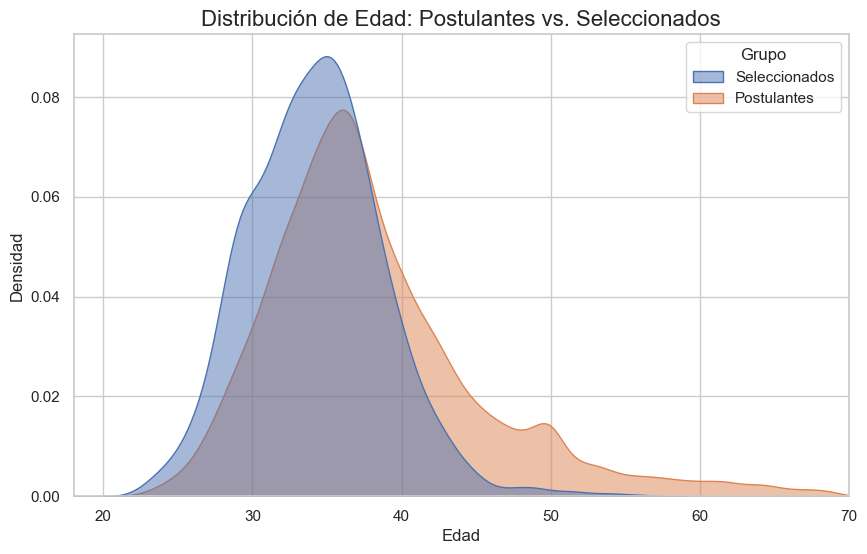

In [69]:
df_sel_comp = df_eda_seleccionados[['Edad']].copy()
df_sel_comp['Grupo'] = 'Seleccionados'


df_gen_comp = df_eda_general[['Edad']].copy()
df_gen_comp['Grupo'] = 'Postulantes'


df_comparativo_edad = pd.concat([df_sel_comp, df_gen_comp])

df_comparativo_edad = df_comparativo_edad.dropna(subset=['Edad'])
df_comparativo_edad = df_comparativo_edad[
    (df_comparativo_edad['Edad'] > 18) & (df_comparativo_edad['Edad'] < 70)
]

plt.figure(figsize=(10, 6))
ax = sns.kdeplot(
    data=df_comparativo_edad,
    x='Edad',
    hue='Grupo',
    fill=True,
    alpha=0.5,
    common_norm=False
)

ax.set_title('Distribución de Edad: Postulantes vs. Seleccionados', fontsize=16)
ax.set_xlabel('Edad')
ax.set_ylabel('Densidad')
ax.set(xlim=(18, 70))
plt.show();

C:\Users\sebap\AppData\Local\Temp\ipykernel_31632\1331997775.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel_temp['Año'] = df_sel_temp['Año'].astype(int)


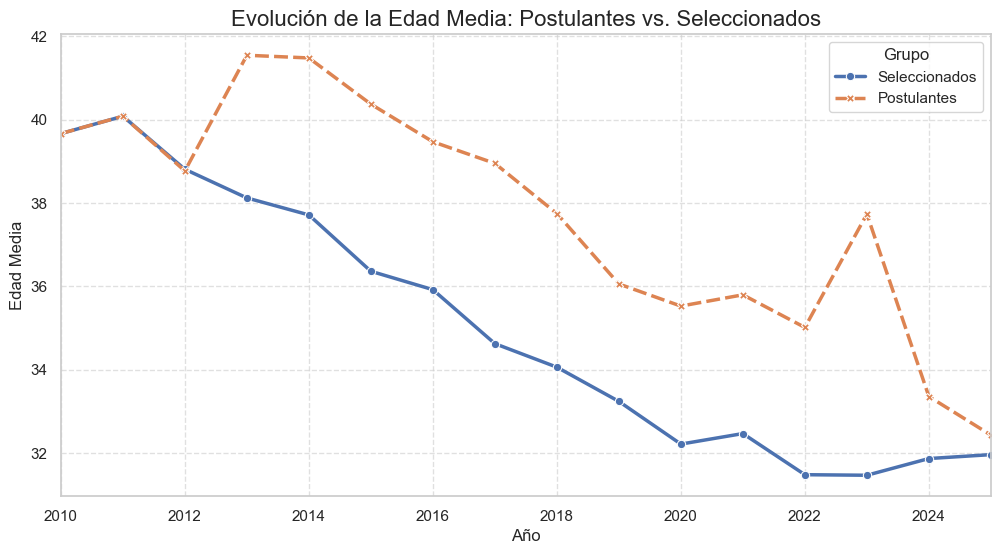

In [70]:
df_gen_temp = df_eda_general.rename(columns={'Año Pech': 'Año'})
df_gen_temp = df_gen_temp.dropna(subset=['Año', 'Edad'])
df_gen_temp['Año'] = df_gen_temp['Año'].astype(int)


df_sel_temp = df_eda_seleccionados.dropna(subset=['Año', 'Edad'])
df_sel_temp['Año'] = df_sel_temp['Año'].astype(int)


avg_age_sel = df_sel_temp.groupby('Año')['Edad'].mean().reset_index(name='Edad Media')
avg_age_sel['Grupo'] = 'Seleccionados'

avg_age_gen = df_gen_temp.groupby('Año')['Edad'].mean().reset_index(name='Edad Media')
avg_age_gen['Grupo'] = 'Postulantes'

df_comparativo_temporal = pd.concat([avg_age_sel, avg_age_gen])


plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=df_comparativo_temporal,
    x='Año',
    y='Edad Media',
    hue='Grupo',
    style='Grupo',
    markers=True,
    linewidth=2.5
)

ax.set_title('Evolución de la Edad Media: Postulantes vs. Seleccionados', fontsize=16)
ax.set_xlabel('Año')
ax.set_ylabel('Edad Media')
ax.set(xlim=(2010, 2025))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Grupo')
plt.show();

Al observar ambos gráficos, se aprecia una clara tendencia al rejuvenecimiento en las edades tanto de los postulantes como de los seleccionados a lo largo de los años. En los últimos periodos, la edad media de los seleccionados se ha mantenido alrededor de cuatro años por debajo de la de los postulantes, lo que sugiere que los candidatos más jóvenes tienden a tener mayores probabilidades de ser seleccionados.

Esta diferencia constante plantea una interrogante relevante: ¿la edad actúa realmente como un factor determinante en el proceso de selección, o más bien el enfoque institucional hacia postulantes más jóvenes ha provocado una disminución en la participación de personas mayores?

### 5.1.2 Analisis de tendencias etarias en los procesos de seleccion

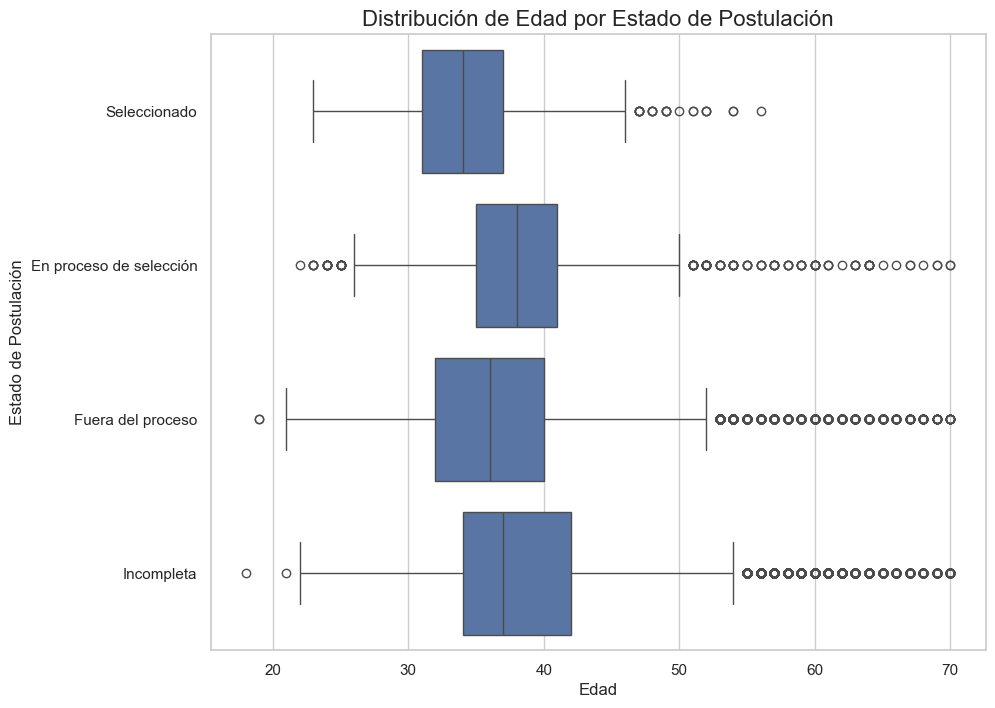

In [71]:
plt.figure(figsize=(10, 8))

sns.boxplot(data=df_eda_general,
            x='Edad',
            y='Resumen Estado Postulación')


plt.title('Distribución de Edad por Estado de Postulación', fontsize=16)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Estado de Postulación', fontsize=12)

plt.show()

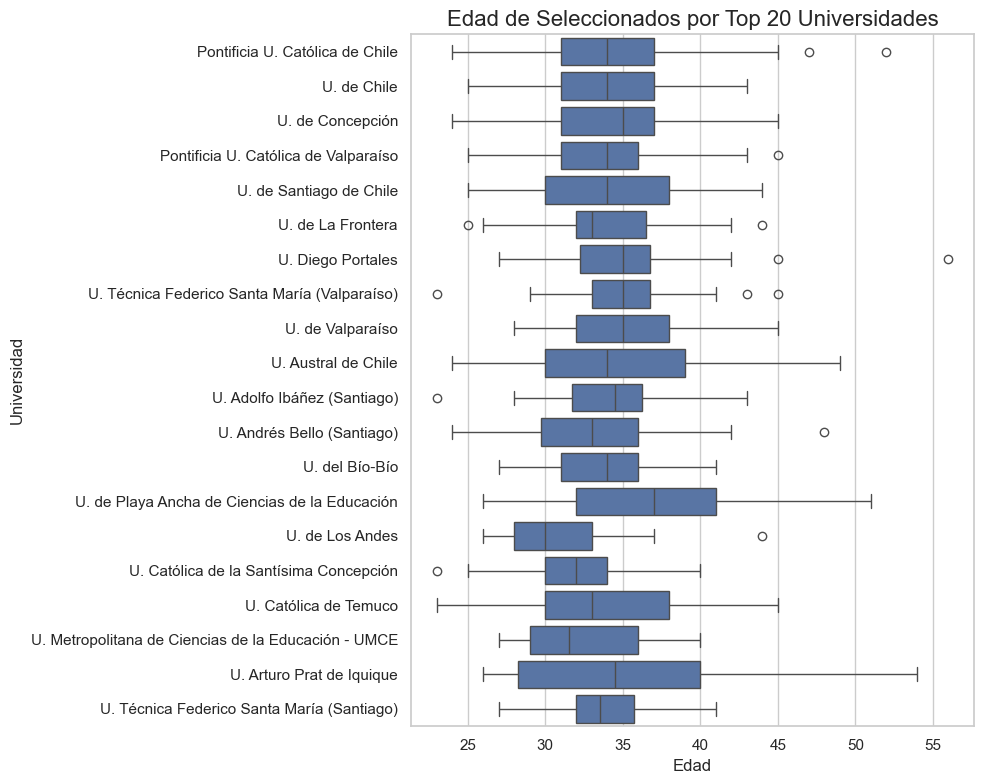

In [72]:
conteo_universidades = df_eda_seleccionados['Universidad'].value_counts()

N = 20
universidades_top_N = conteo_universidades.head(N).index

df_top_N = df_eda_seleccionados[
    df_eda_seleccionados['Universidad'].isin(universidades_top_N)
]


plt.figure(figsize=(10, 8))


sns.boxplot(data=df_top_N,
            x='Edad',
            y='Universidad',
            order=universidades_top_N)

plt.title(f'Edad de Seleccionados por Top {N} Universidades', fontsize=16)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Universidad', fontsize=12)
plt.tight_layout()
plt.show()
plt.show()

Se puede observar de los gráficos que la mayoría de los postulantes se concentran entre los 30 y 40 años, este rango etario también predomina entre los seleccionados, lo que sugiere que se favorece a perfiles con cierta experiencia profesional.
Los postulantes mas jóvenes tienden ser quienes no completan su postulación o quedan fuera del proceso, mientras que el rango etario de mayores de 50 años participan en menor medida.
En cuanto a las universidades, se puede observar que los seleccionados de universidades privadas de la región metropolitana presentan edades mas bajas, mientras que los provenientes de universidades regionales o tradicionales presentan edades mayores, esto refleja diversidad etaria del grupo seleccionado.

### 5.1.3 Analisis de distribucion entre universidades, carrera y edad

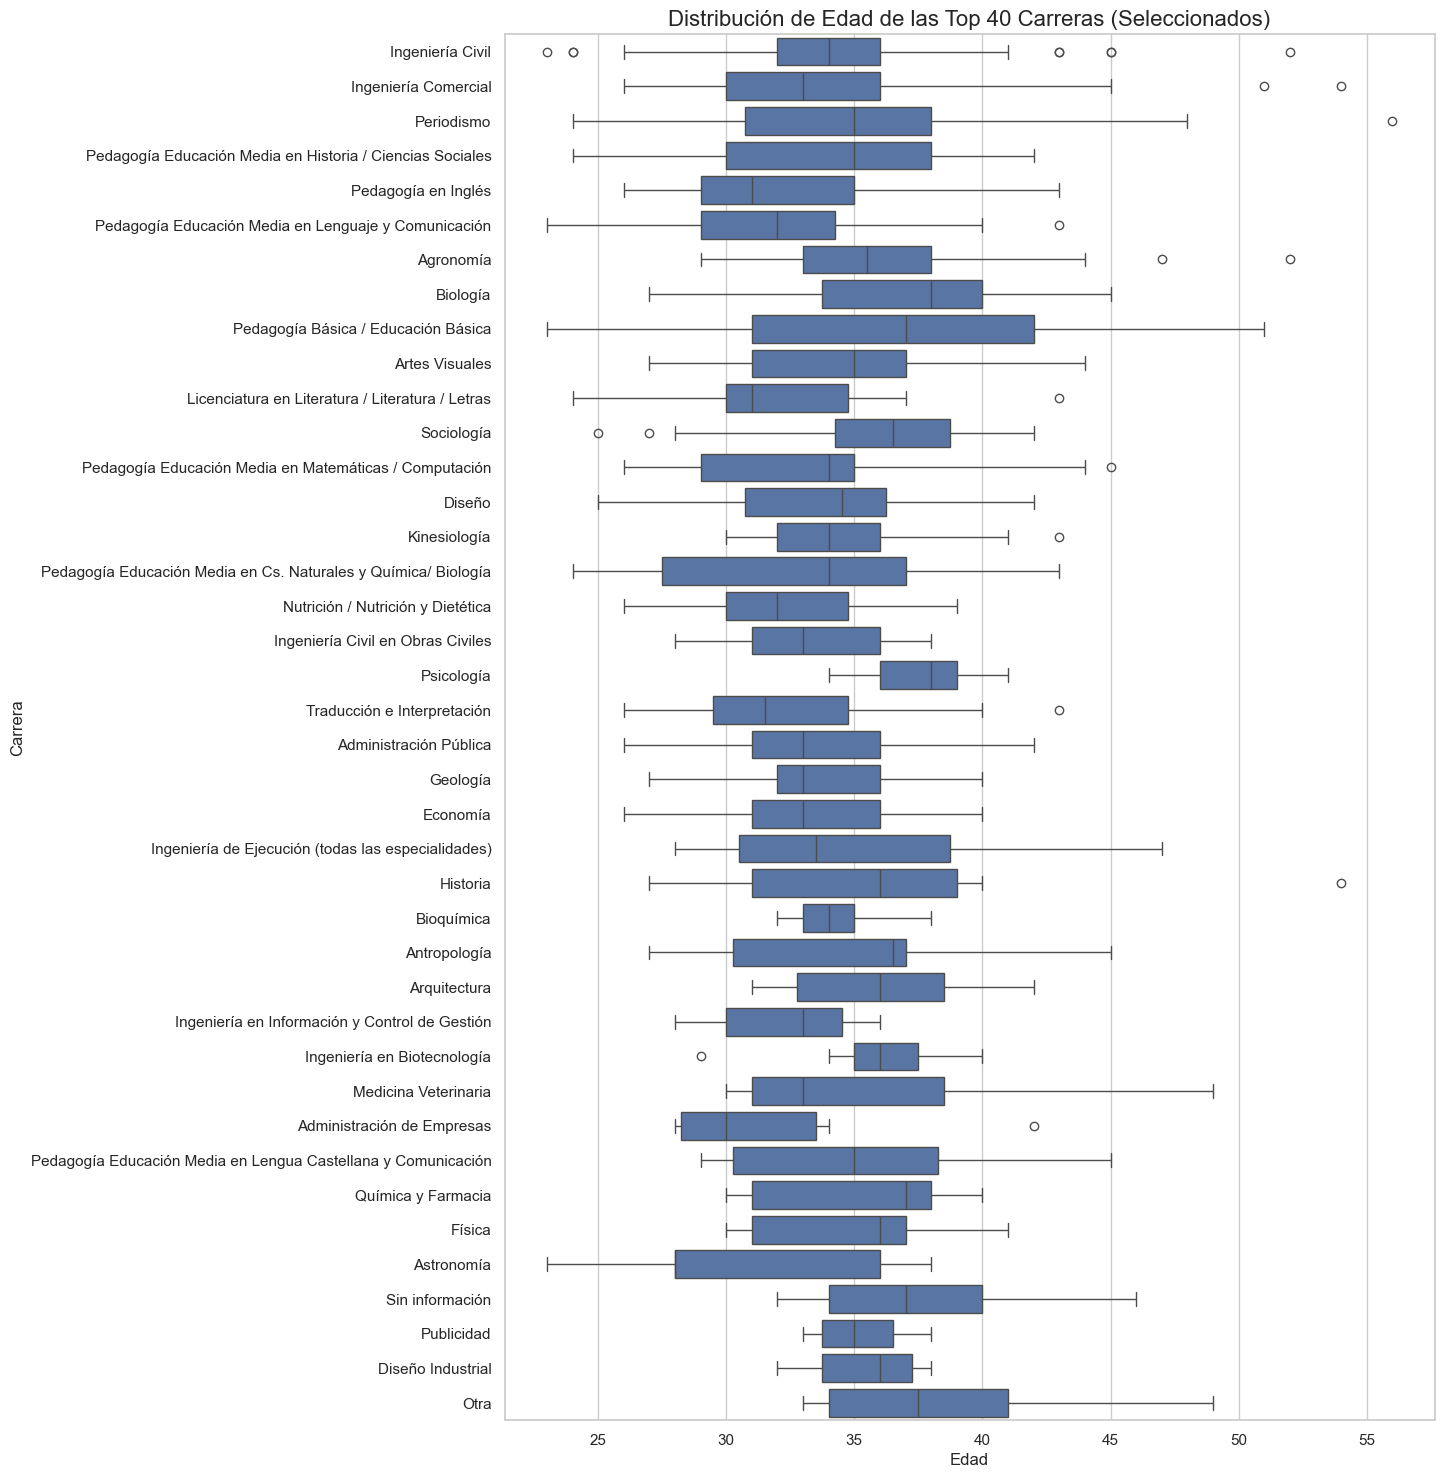

In [73]:
N = 40

# Contamos cuántos seleccionados hay por carrera
conteo_carreras = df_eda_seleccionados['Carrera'].value_counts()

# Obtenemos la lista de las Top N carreras (sus nombres)
carreras_top_N = conteo_carreras.head(N).index

# Filtramos el DataFrame para quedarnos solo con las filas de esas Top N carreras
df_filtrado_topN = df_eda_seleccionados[
    df_eda_seleccionados['Carrera'].isin(carreras_top_N)
]
altura_figura = max(15, N * 0.45)

fig, ax = plt.subplots(1, 1, figsize=(12, altura_figura))

sns.boxplot(
    data=df_filtrado_topN,
    x='Edad',
    y='Carrera',
    order=carreras_top_N,
    ax=ax
)

ax.set_title(f'Distribución de Edad de las Top {N} Carreras (Seleccionados)', fontsize=16)
ax.set_xlabel('Edad', fontsize=12)
ax.set_ylabel('Carrera', fontsize=12)


plt.show()

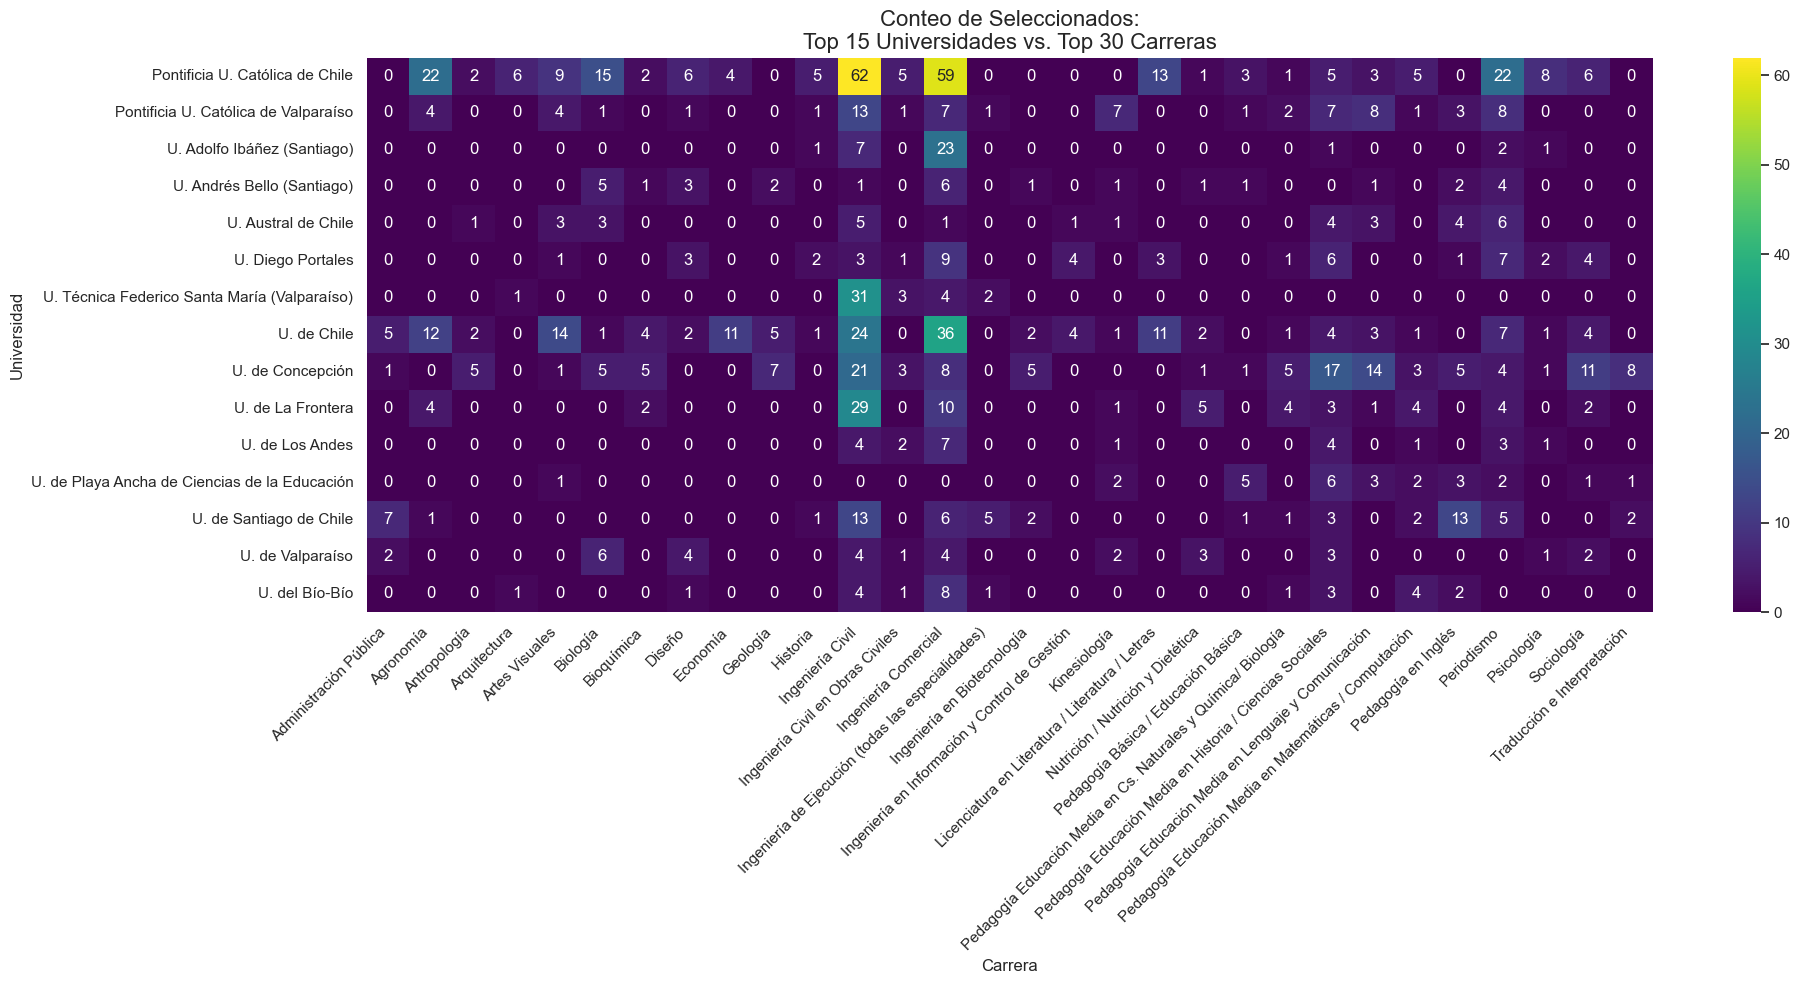

In [74]:
N_universidades = 15
N_carreras = 30

conteo_universidades = df_eda_seleccionados['Universidad'].value_counts()
top_universidades = conteo_universidades.head(N_universidades).index


conteo_carreras = df_eda_seleccionados['Carrera'].value_counts()
top_carreras = conteo_carreras.head(N_carreras).index


df_filtrado_heatmap = df_eda_seleccionados[
    df_eda_seleccionados['Universidad'].isin(top_universidades) &
    df_eda_seleccionados['Carrera'].isin(top_carreras)
]

tabla_contingencia = pd.crosstab(
    df_filtrado_heatmap['Universidad'],
    df_filtrado_heatmap['Carrera']
)


fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.heatmap(
    tabla_contingencia,
    annot=True,
    fmt='d',
    cmap='viridis',
    ax=ax
)


ax.set_title(f'Conteo de Seleccionados:\nTop {N_universidades} Universidades vs. Top {N_carreras} Carreras', fontsize=16)
ax.set_xlabel('Carrera', fontsize=12)
ax.set_ylabel('Universidad', fontsize=12)


plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

fig.tight_layout()
plt.show()

## 5.2 Tendencias en el tiempo (por universidad/carrera)
Para cumplir con los objetivos del proyecto, no basta con saber qué universidades o carreras tienen más seleccionados en total. Necesitamos entender la evolución y la consistencia de estas cifras (Objetivos 1 y 2). El reclutamiento es un proceso dinámico; las universidades que eran prioritarias hace una década podrían no serlo hoy.

Para analizar las tendencias, se generaron tres visualizaciones clave, cada una con un propósito específico. En todas ellas, se decidió filtrar por el "Top 10" (de universidades o carreras) como un equilibrio y para mayor legibilidad, dado que mostrar todas las categorías resultaría en un gráfico de indescifrable.

In [75]:
# @title
df_general_temporal = df_eda_general.rename(columns={'Año Pech': 'Año'})
df_general_temporal = df_general_temporal.dropna(subset=['Año'])
df_general_temporal['Año'] = df_general_temporal['Año'].astype(int)

df_seleccionados_temporal = df_eda_seleccionados.dropna(subset=['Año'])
df_seleccionados_temporal['Año'] = df_seleccionados_temporal['Año'].astype(int)

C:\Users\sebap\AppData\Local\Temp\ipykernel_31632\1586719865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seleccionados_temporal['Año'] = df_seleccionados_temporal['Año'].astype(int)


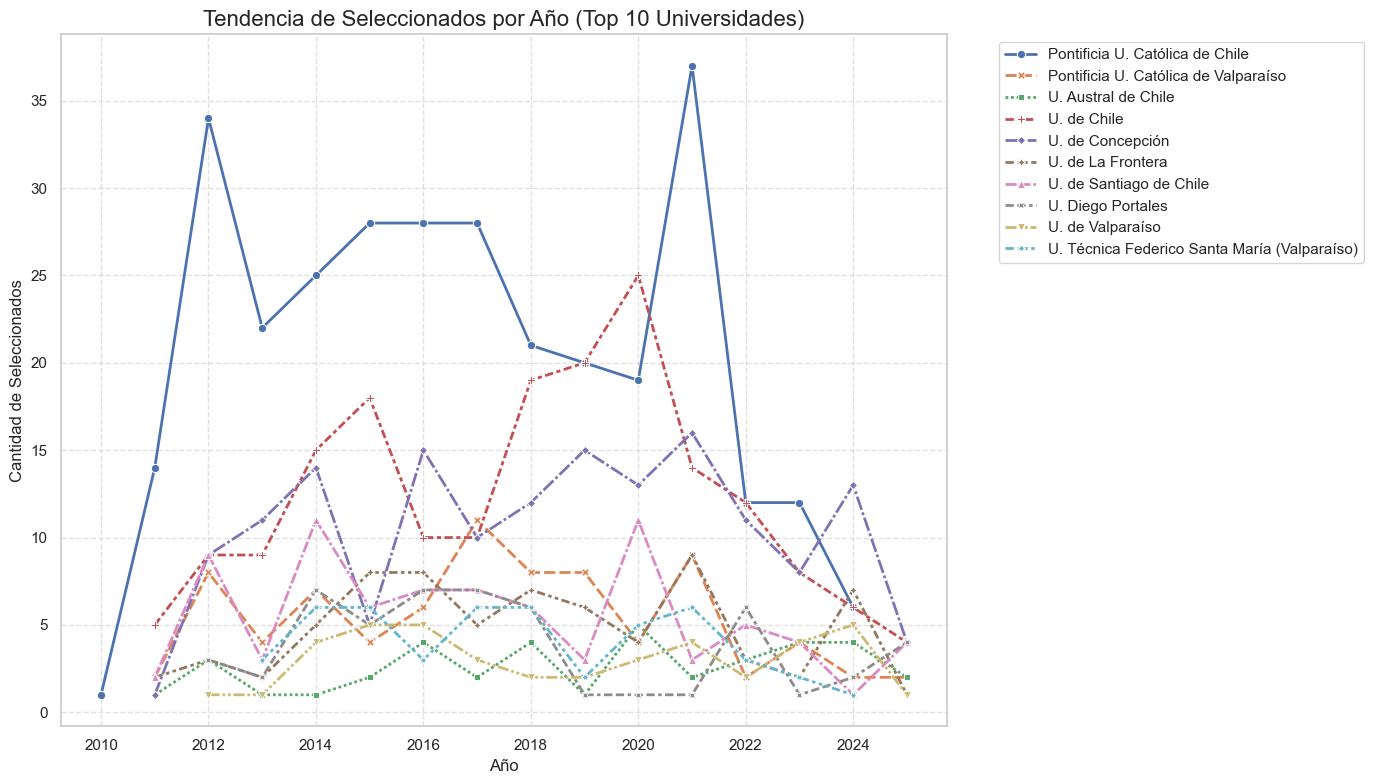

In [76]:
# @title


N_Ues = 10
top_universidades = df_seleccionados_temporal['Universidad'].value_counts().head(N_Ues).index


df_seleccionados_top_u = df_seleccionados_temporal[
    df_seleccionados_temporal['Universidad'].isin(top_universidades)
]


tendencia_por_universidad = df_seleccionados_top_u.groupby(
    ['Año', 'Universidad']
).size().reset_index(name='Cantidad Seleccionados')

plt.figure(figsize=(14, 8))
sns.lineplot(data=tendencia_por_universidad,
             x='Año',
             y='Cantidad Seleccionados',
             hue='Universidad',
             style='Universidad',
             markers=True,
             linewidth=2)

plt.title(f'Tendencia de Seleccionados por Año (Top {N_Ues} Universidades)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Seleccionados', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show();

Este gráfico muestra el conteo absoluto de seleccionados provenientes de las 10 universidades con más seleccionados históricos.

Resultados y Conclusiones Preliminares:

- Es evidente que la Pontificia U. Católica de Chile (línea azul sólida) y la U. de Chile (línea verde punteada) dominan en términos de volumen de seleccionados, superandoa las demás.

- Las cifras no son estables. Se observa un peak extremo para la PUC alrededor de 2021. Esto genera la pregunta:
  1. ¿Qué ocurrió ese año?
  2. ¿Se llevo a cabo una campaña de  reclutamiento diferente?
  3. ¿Fue un efecto de la pandemia?

- Casi todas las universidades muestran una fuerte caída en el número de seleccionados después de 2021-2022. Esto debe investigarse.
  1. ¿Es un reflejo de datos incompletos?
  2. ¿Es una señal de una crisis en el reclutamiento de Enseña Chile?

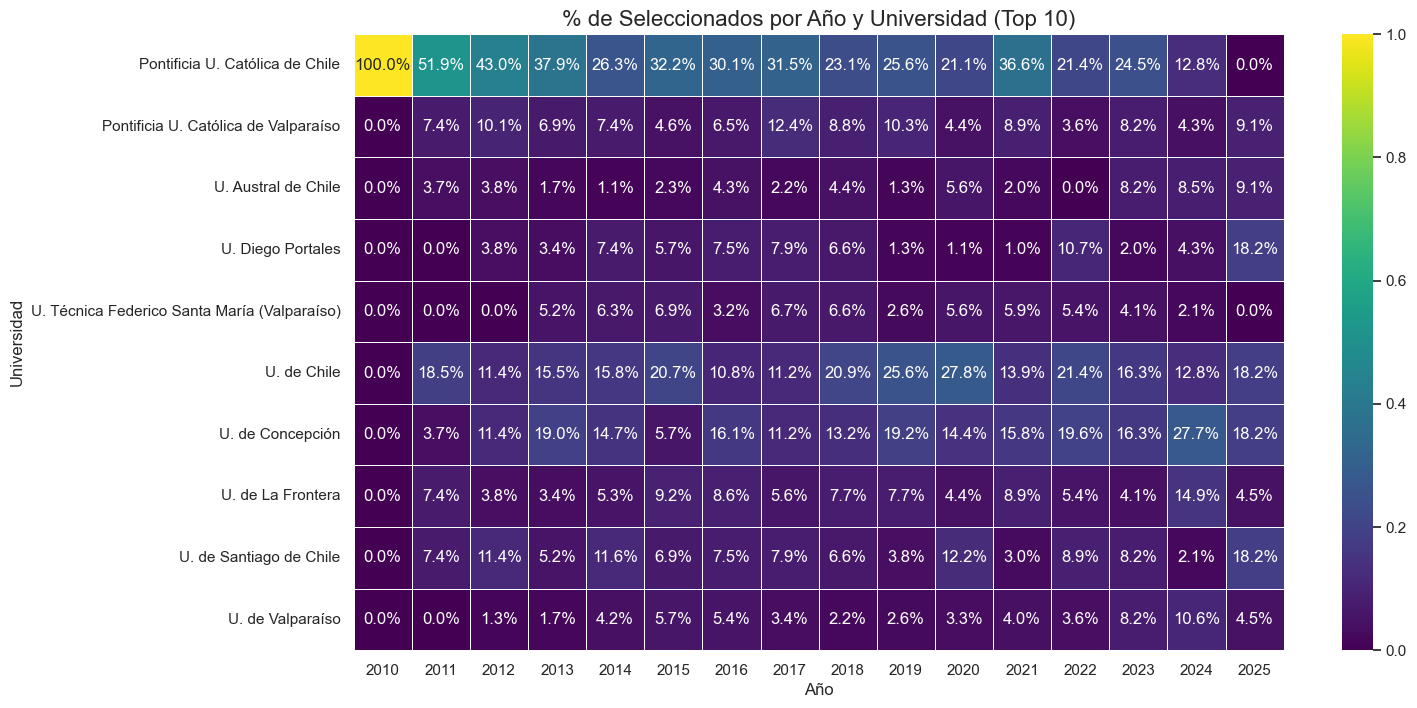

In [77]:
# @title
df_pivot_u = tendencia_por_universidad.pivot_table(
    index='Universidad',
    columns='Año',
    values='Cantidad Seleccionados'
).fillna(0)

df_pivot_u_norm = df_pivot_u.apply(lambda x: x / x.sum(), axis=0)


plt.figure(figsize=(15, 8))
sns.heatmap(df_pivot_u_norm,
            annot=True,
            fmt='.1%',
            cmap='viridis',
            linewidths=.5)

plt.title(f'% de Seleccionados por Año y Universidad (Top {N_Ues})', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Universidad', fontsize=12)
plt.show();

Este grafico muestra qué porcentaje del total de seleccionados de un año específico aportó cada una de las Top 10 universidades.

Resultados y Conclusiones Preliminares:

Este gráfico responde directamente a la Pregunta 5. Confirma que la concentración en la PUC y U. de Chile es real. En la mayoría de los años, estas dos instituciones suman entre el 40% y el 60% de todos los seleccionados  Esto sugiere un fuerte sesgo histórico hacia estas instituciones.

La U. de Concepción y PUCV muestran una participación proporcional consistente (8%-15%) del total anual. Esto las posiciona como objetivos de reclutamiento fiables.

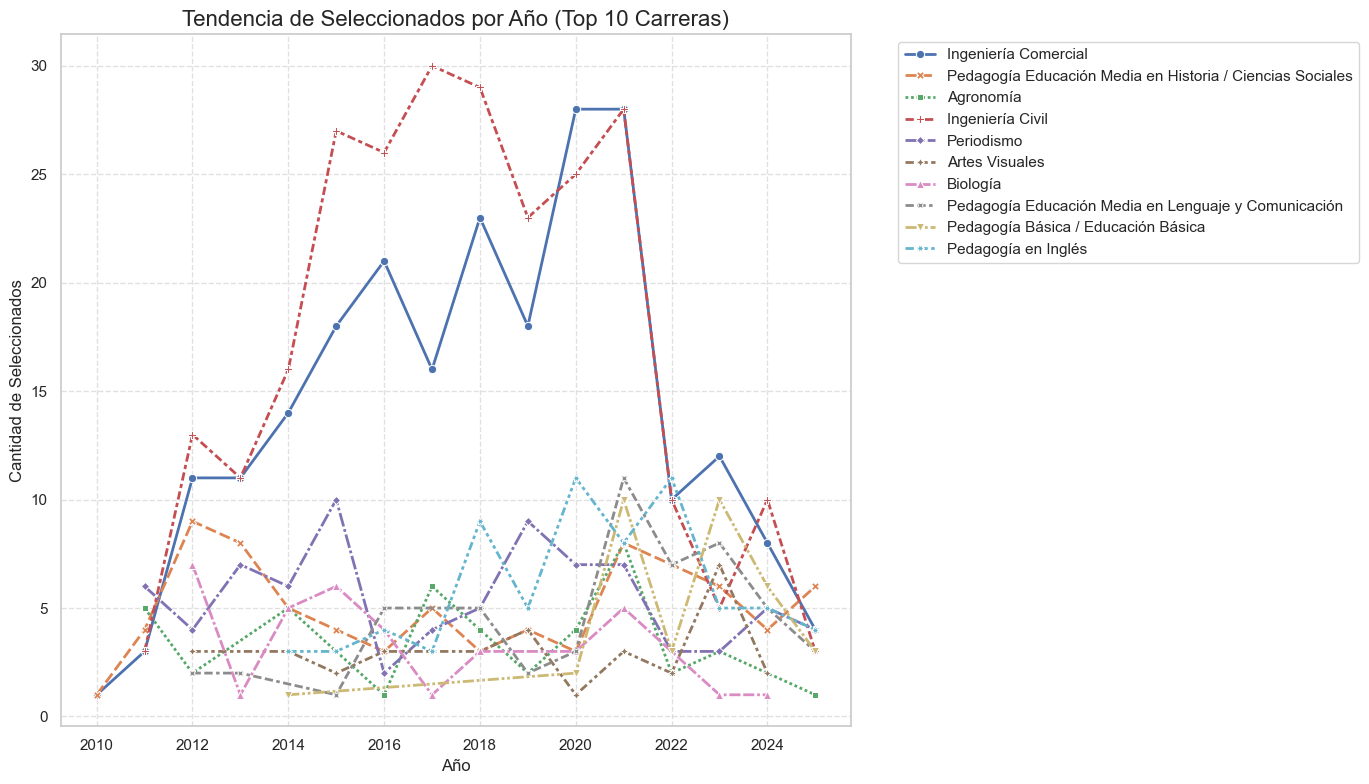

In [78]:
# @title
N_Carreras = 10
top_carreras = df_seleccionados_temporal['Carrera'].value_counts().head(N_Carreras).index

df_seleccionados_top_c = df_seleccionados_temporal[
    df_seleccionados_temporal['Carrera'].isin(top_carreras)
]

tendencia_por_carrera = df_seleccionados_top_c.groupby(
    ['Año', 'Carrera']
).size().reset_index(name='Cantidad Seleccionados')

plt.figure(figsize=(14, 8))
sns.lineplot(data=tendencia_por_carrera,
             x='Año',
             y='Cantidad Seleccionados',
             hue='Carrera',
             style='Carrera',
             markers=True,
             linewidth=2)

plt.title(f'Tendencia de Seleccionados por Año (Top {N_Carreras} Carreras)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Seleccionados', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show();

El grafico muestra el número de seleccionados provenientes de las 10 carreras más frecuentes en la historia del programa.

Resultados y Conclusiones Preliminares:

- El hallazgo más importante es la dominancia de dos carreras: Ingenieria Civil (línea roja punteada) e Ingeniería Comercial (línea azul). Históricamente, estas dos carreras son las que mas aportan a los seleccionados.

- Esto impacta directamente el Objetivo 3 (identificar carreras prioritarias). Estas dos son, por volumen, las más importantes.

- Este gráfico genera preguntas interesantes para Enseña Chile:

  1. ¿Por qué estas dos carreras? ¿Son el foco principal de las campañas de reclutamiento? ¿O son las que calzan con el perfil de reclutamiento?

  2. ¿Por qué carreras aparentemente más alineadas con la misión como las Pedagogías tienen números tan bajos?

  3. ¿Desea la fundación diversificar este perfil?

# 6. Estimación de Candidatos Idóneos (Entrega 2)

## 6.1 Definición del perfil idóneo
Perfil idóneo:

A. Características generales:

1. Profesionales con edad máxima 30 años (deseable, no excluyente)

2. Posibilidad de impartir matemáticas o lenguaje.

B. Competencias:

1. Experiencias de liderazgo.

2. Alineación a la visión de Enseña Chile.

3. Apertura al feedback.

4. Relaciones interpersonales.

## 6.2 Estimar cuántos candidatos idóneos hay por universidad-carrera

# 7. Categorización de Universidades y Carreras (Entrega 2)

## 7.1 Definir criterios
- Proporción de seleccionados
- Número estimado de candidatos idóneos
- Alineación histórica al perfil exitoso

## 7.2 Crear categorías: Alta, Media, Baja prioridad

## 7.3 Visualización final de categorías

#8. Modelado Predictivo (Entrega 2)

## 8.1 Objetivo: predecir la probabilidad de selección

X: edad, universidad, carrera, experiencia, etc.

y: seleccionado (sí/no)

## 8.2 Modelos posibles
- Logistic Regression
- Random Forest
- Árboles de decisión

## 8.3 Evaluación y métricas